<table style="margin-left: 0;">
    <tr>
        <td colspan="5" style="text-align: center;"><h2><b>Portfolio 2 - Deep Learning</b></h2></td>
    </tr>
    <tr>
        <th>Coach</th>
        <th>Opdrachtnummer</th>
        <th>Namen groepsleden</th>
        <th>Kaggle naam</th>
    </tr>
    <tr>
        <td><span style="color:blue">Vikram en Bob</span></td>
        <td><span style="color:blue">2</span></td>
        <td>
            <ul style="list-style-type:none; padding-left:0;">
                <li><b>Mark Olieman:</b> <span style="color:green">19054033</span></li>
                <li><b>Johan Heskes:</b> <span style="color:green">22132376</span></li>
                <li><b>Henry Lau:</b> <span style="color:green">22122958</span></li>
                <li><b>Isa Dijkstra:</b> <span style="color:green">22119485</span></li>
            </ul>
        </td>
        <td><span style="color:blue">???</span></td>
    </tr>
</table>

    
    
## Inhoudsopgave

- [**Inleiding**](#inleiding)
- [**Packages en de data inladen**](#data)
- [**Opdracht 1 - EDA**](#eda)
- [**Opdracht 2 - LSTM voor audioclips**](#audio)
- [**Opdracht 3 - LSTM voor songteksten**](#song_lstm)
- [**Opdracht 4 - Transformer voor songteksten**](#song_tran)
- [**Opdracht 5 - Model naar keuze**](#mnk)
- [**Opdracht 6 - Bevindingen**](#bevindingen)
- [**Opdracht 7 - Conclusie en aanbevelingen**](#conclusie)
- [**Bronnenlijst**](#bronnenlijst)

## Inleiding <a name='inleiding'></a>

In dit notebook gaan we aan de hand van songteksten en audiodata, audiotracks in verschillende genres classificeren

## Packages en de data inladen <a name='data'></a>

In [1]:
import os
import re
import nltk
from nltk.tokenize import word_tokenize
import string
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding, TextVectorization


In [2]:
#songteksten inladen

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
test


,filename,lyrics
0,test.00000.wav,[Instrumental Intro]\r\n(Radio)\r\n(Radio)\r\n...
1,test.00001.wav,[Verse 1]\r\nThere's an old Kodak camera in my...
2,test.00002.wav,"[Intro]\r\nSo curious, so curious\r\n\r\n[Vers..."
3,test.00003.wav,[Intro]\r\nWhere do I take this pain of mine\r...
4,test.00004.wav,"[Verse 1]\r\nBaby's into runnin' around, hangi..."
...,...,...
124,test.00124.wav,Heaven must be missing an angel\r\nMissing one...
125,test.00125.wav,[Verse 1]\r\nLaura and Tommy were lovers\r\nHe...
126,test.00126.wav,"[Chorus: Agnetha & Frida, Benny & Björn]\r\nIf..."
127,test.00127.wav,[Chorus]\r\nLegalize it\r\nAnd don't criticize...


In [4]:
#Train en validation set inladen

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='Train',
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=5*16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 537 files belonging to 8 classes.
Using 430 files for training.
Using 107 files for validation.

label names: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


In [5]:
len(label_names)

8

In [6]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
#test dataset inladen

test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='Test',
    label_mode=None,
    batch_size=32,
    seed=0,
    output_sequence_length=5*16000)

print()

Found 129 files belonging to 1 classes.



In [8]:
train_ds = train_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

## **Opdracht 1 - EDA** <a name='eda'></a>

In [9]:
display(train.head())
display(train.describe())
display(train.isnull().sum())

TypeError: 'module' object is not callable

(32, 80000)
(32,)


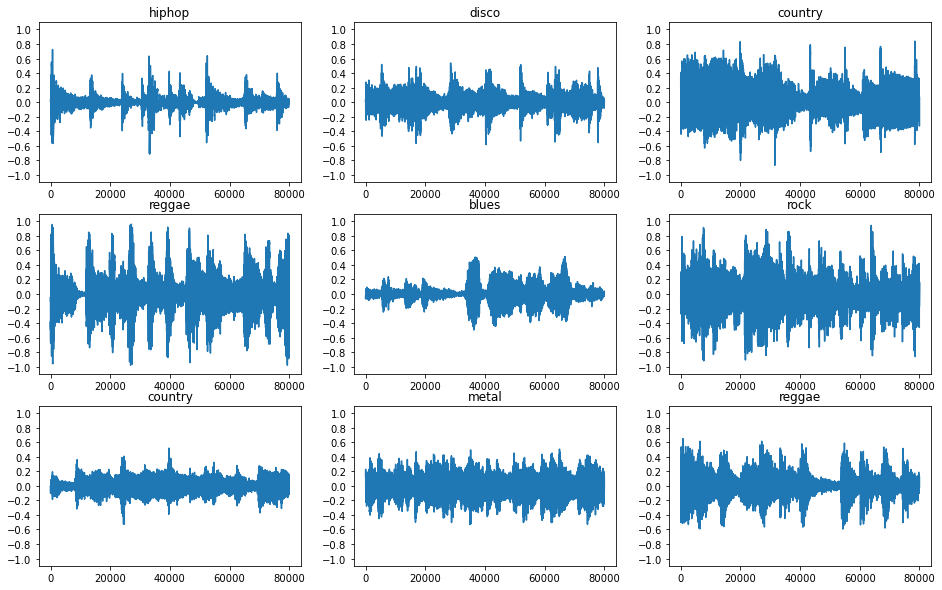

In [10]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

label_names[[1,1,0,0]]
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

## Opdracht 2 - LSTM voor audioclips <a name='audio'></a>

In [11]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=512, frame_step=256)

    # Obtain the magnitude of the STFT (use tf.abs).
    spectrogram = tf.abs(spectrogram)

    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram

In [12]:
def make_spec_ds(ds):
    return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [14]:
#even kijken of het zo werkt
def make_spec_ds(ds):
    return ds.map(
      map_func=lambda audio: (get_spectrogram(audio),),  # Geen label doorgeven
      num_parallel_calls=tf.data.AUTOTUNE)

test_spectrogram_ds = make_spec_ds(test_ds)


In [15]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [16]:
def spectrogram_to_mfcc(spectrograms, num_mel_bins=128, num_coefficients=13, sample_rate=16000):
    """
    Convert a batch of spectrograms to a batch of 1D time series of MFCCs.

    Parameters:
    - spectrograms: A TensorFlow Tensor representing a batch of spectrograms with shape (batch_size, 311, 257, 1).
    - num_mel_bins: Number of Mel bins to use.
    - num_coefficients: Number of MFCC coefficients to return.
    - sample_rate: Sample rate of the audio.

    Returns:
    - A TensorFlow Tensor containing the MFCCs with shape (batch_size, num_frames, num_coefficients).
    """
    # Remove the last dimension (channel dimension, if it's 1)
    spectrograms = tf.squeeze(spectrograms, axis=-1)

    # Compute Mel spectrograms
    stfts_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=spectrograms.shape[-1],
        sample_rate=sample_rate,
        lower_edge_hertz=20.0,
        upper_edge_hertz=sample_rate / 2)
    mel_spectrograms = tf.tensordot(spectrograms, stfts_to_mel_matrix, 1)
    # Shape tuning for the mel spectrograms as expected
    mel_spectrograms.set_shape(spectrograms.shape[:-1] + (num_mel_bins,))

    # Logarithmic scaling
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_coefficients]

    return mfccs

In [17]:
def make_MFCC_ds(ds):
    return ds.map(
      map_func=lambda spectrogram,label: (spectrogram_to_mfcc(spectrogram), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_MFCC_ds = make_MFCC_ds(train_spectrogram_ds)
val_MFCC_ds = make_MFCC_ds(val_spectrogram_ds)

In [19]:
#even kijken of het zo werkt
def make_MFCC_ds(ds):
    return ds.map(
      map_func=lambda spectrogram: (spectrogram_to_mfcc(spectrogram)),
      num_parallel_calls=tf.data.AUTOTUNE)

test_MFCC_ds = make_MFCC_ds(test_spectrogram_ds)

In [20]:
train_MFCC_ds = train_MFCC_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_MFCC_ds = val_MFCC_ds.cache().prefetch(tf.data.AUTOTUNE)
test_MFCC_ds = test_MFCC_ds.cache().prefetch(tf.data.AUTOTUNE)

In [21]:
model_lstm = models.Sequential([
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=32)),
    Dropout(0.2),
    Dense(8, activation='softmax')
])


In [22]:
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [23]:
EPOCHS = 50

history = model_lstm.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
)

Epoch 1/50


14/14 [==============================] - 14s 342ms/step - loss: 1.9979 - accuracy: 0.1930 - val_loss: 1.8618 - val_accuracy: 0.2523
Epoch 2/50
14/14 [==============================] - 3s 195ms/step - loss: 1.7571 - accuracy: 0.3837 - val_loss: 1.7240 - val_accuracy: 0.3271
Epoch 3/50
14/14 [==============================] - 3s 215ms/step - loss: 1.5897 - accuracy: 0.4279 - val_loss: 1.6516 - val_accuracy: 0.3551
Epoch 4/50
14/14 [==============================] - 3s 192ms/step - loss: 1.4740 - accuracy: 0.4628 - val_loss: 1.5947 - val_accuracy: 0.3645
Epoch 5/50
14/14 [==============================] - 3s 188ms/step - loss: 1.3745 - accuracy: 0.5070 - val_loss: 1.5529 - val_accuracy: 0.3364
Epoch 6/50
14/14 [==============================] - 3s 199ms/step - loss: 1.2721 - accuracy: 0.5233 - val_loss: 1.5056 - val_accuracy: 0.3925
Epoch 7/50
14/14 [==============================] - 3s 183ms/step - loss: 1.1730 - accuracy: 0.5605 - val_loss: 1.4851 - val_accuracy: 0.4112
Epo

In [24]:
del model_lstm
model_lstm = models.Sequential([
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=32)),
    Dropout(0.2),
    Dense(8, activation='softmax')
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 50

history = model_lstm.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
)

Epoch 1/50
14/14 [==============================] - 10s 268ms/step - loss: 1.9956 - accuracy: 0.2209 - val_loss: 1.9216 - val_accuracy: 0.2804
Epoch 2/50
14/14 [==============================] - 2s 174ms/step - loss: 1.7430 - accuracy: 0.3651 - val_loss: 1.7759 - val_accuracy: 0.3271
Epoch 3/50
14/14 [==============================] - 2s 175ms/step - loss: 1.6015 - accuracy: 0.4302 - val_loss: 1.7377 - val_accuracy: 0.3551
Epoch 4/50
14/14 [==============================] - 2s 179ms/step - loss: 1.5026 - accuracy: 0.4791 - val_loss: 1.6539 - val_accuracy: 0.4112
Epoch 5/50
14/14 [==============================] - 3s 222ms/step - loss: 1.3561 - accuracy: 0.5395 - val_loss: 1.6665 - val_accuracy: 0.3645
Epoch 6/50
14/14 [==============================] - 3s 219ms/step - loss: 1.2452 - accuracy: 0.5628 - val_loss: 1.6120 - val_accuracy: 0.3645
Epoch 7/50
14/14 [==============================] - 3s 201ms/step - loss: 1.1508 - accuracy: 0.6302 - val_loss: 1.4951 - val_accuracy: 0.4299
Epoch

In [25]:
model_lstm = models.Sequential([
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=32, return_sequences=True)),  # Extra LSTM-laag met return_sequences=True
    Dropout(0.2),
    Bidirectional(LSTM(units=16)),  # Nog een LSTM-laag zonder return_sequences=True
    Dropout(0.2),
    Dense(64, activation='relu'),  # Extra dense-laag
    Dropout(0.2),
    Dense(8, activation='softmax')
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 10
history = model_lstm.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
)

Epoch 1/10
14/14 [==============================] - 15s 388ms/step - loss: 2.0384 - accuracy: 0.1674 - val_loss: 1.9572 - val_accuracy: 0.3364
Epoch 2/10
14/14 [==============================] - 4s 306ms/step - loss: 1.8930 - accuracy: 0.3279 - val_loss: 1.8353 - val_accuracy: 0.3271
Epoch 3/10
14/14 [==============================] - 5s 345ms/step - loss: 1.7987 - accuracy: 0.3419 - val_loss: 1.7459 - val_accuracy: 0.3551
Epoch 4/10
14/14 [==============================] - 6s 447ms/step - loss: 1.6998 - accuracy: 0.3698 - val_loss: 1.6844 - val_accuracy: 0.3271
Epoch 5/10
14/14 [==============================] - 5s 367ms/step - loss: 1.5938 - accuracy: 0.4163 - val_loss: 1.6271 - val_accuracy: 0.3551
Epoch 6/10
14/14 [==============================] - 5s 344ms/step - loss: 1.5313 - accuracy: 0.4628 - val_loss: 1.5906 - val_accuracy: 0.3458
Epoch 7/10
14/14 [==============================] - 7s 476ms/step - loss: 1.3950 - accuracy: 0.4698 - val_loss: 1.6172 - val_accuracy: 0.3925
Epoch

In [26]:
del model_lstm
model_lstm = models.Sequential([
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 50

history = model_lstm.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
)


Epoch 1/50
14/14 [==============================] - 25s 802ms/step - loss: 1.9946 - accuracy: 0.2000 - val_loss: 1.8622 - val_accuracy: 0.3084
Epoch 2/50
14/14 [==============================] - 9s 631ms/step - loss: 1.8361 - accuracy: 0.3279 - val_loss: 1.7310 - val_accuracy: 0.3458
Epoch 3/50
14/14 [==============================] - 8s 589ms/step - loss: 1.7161 - accuracy: 0.4000 - val_loss: 1.6639 - val_accuracy: 0.3551
Epoch 4/50
14/14 [==============================] - 8s 597ms/step - loss: 1.6158 - accuracy: 0.4140 - val_loss: 1.5829 - val_accuracy: 0.3738
Epoch 5/50
14/14 [==============================] - 8s 586ms/step - loss: 1.5259 - accuracy: 0.4395 - val_loss: 1.5788 - val_accuracy: 0.3645
Epoch 6/50
14/14 [==============================] - 8s 596ms/step - loss: 1.3972 - accuracy: 0.4791 - val_loss: 1.5227 - val_accuracy: 0.3738
Epoch 7/50
14/14 [==============================] - 8s 607ms/step - loss: 1.3520 - accuracy: 0.5395 - val_loss: 1.5153 - val_accuracy: 0.3645
Epoch

Text(0, 0.5, 'Accuracy [%]')

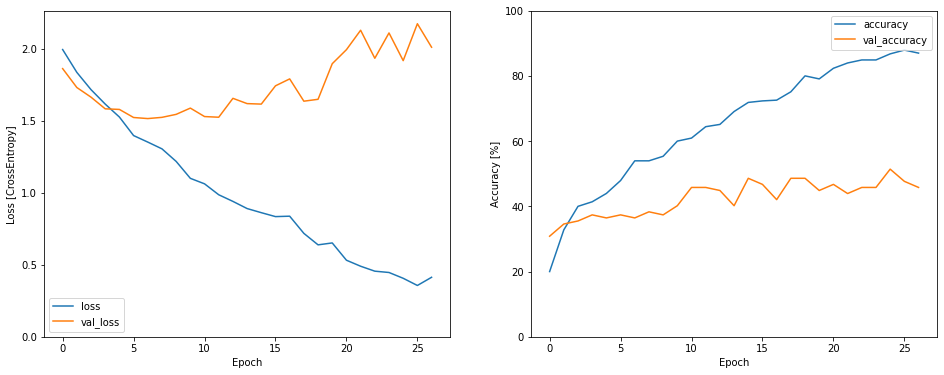

In [27]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Opdracht 3 - LSTM voor songteksten <a name='song_lstm'></a>

## Opdracht 4 - Transformer voor songteksten <a name='song_tran'></a>

## Opdracht 5 - Model naar keuze <a name='mnk'></a>

## Opdracht 6 - Bevindingen <a name='bevindingen'></a>

## Opdracht 7 - Conclusie en aanbevelingen <a name='conclusie'></a>

## Bronnenlijst <a name='bronnenlijst'></a>